This tutorial demonstrates how to read in a particle stack in `cryojax`. The particle stack read here is given in [RELION](https://relion.readthedocs.io/en/release-5.0/) STAR file format.

After reading the particle stack, it is demonstrated how to compute a *power spectrum* using `cryojax`.

In [1]:
# JAX imports
import jax
import equinox as eqx
import jax.numpy as jnp

In [2]:
# Plotting imports and functions
from matplotlib import pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable


def plot_image(image, fig, ax, cmap="gray", label=None, **kwargs):
    im = ax.imshow(image, cmap=cmap, origin="lower", **kwargs)
    divider = make_axes_locatable(ax)
    cax = divider.append_axes("right", size="5%", pad=0.05)
    fig.colorbar(im, cax=cax)
    if label is not None:
        ax.set(title=label)
    return fig, ax

In [3]:
# CryoJAX imports
import cryojax.simulator as cs
from cryojax.data import RelionDataset

First, we will read in the RELION particle stack using the `cryojax` dataset reader `RelionDataset`.

!!! info "What is a `RelionDataset`?"

    CryoJAX implements an abstraction an a dataset in RELION, called a `RelionDataset`. This object takes in a
    RELION STAR file for a particle stack. Upon accessing an image in the particle stack, a `RelionParticleStack`
    is returned. Specifically, the `RelionParticleStack` stores the image(s) in the image stack, as well as the metadata
    in the STAR file. The metadata is used to instantiate compatible `cryojax` objects. For example, the `RelionParticleStack`
    stores a `cryojax` models for the contrast transfer function (the `CTF` class) and the pose (the `EulerAnglePose` class).

    More generally, a `RelionDataset` is an `AbstractDataset`, which is complemented by the abstraction of a particle stack: the `AbstractParticleStack`.
    These abstract interfaces are part of the `cryojax` public API!  

In [6]:
# Read in the dataset and plot an image
dataset = RelionDataset(
    path_to_starfile="./ribosome-relion-env/Extract/job010/particles.star",
    path_to_relion_project="./ribosome-relion-env/",
)
# ... get the zeroth entry in the STAR file
relion_particle = dataset[0]
print(relion_particle)

RelionParticleStack(
  image_stack=f32[320,320],
  config=ImageConfig(
    shape=(320, 320),
    pixel_size=f32[],
    padded_shape=(320, 320),
    pad_mode='constant',
    rescale_method='bicubic',
    wrapped_frequency_grid=FrequencyGrid(array=f32[320,161,2]),
    wrapped_padded_frequency_grid=FrequencyGrid(array=f32[320,161,2]),
    wrapped_coordinate_grid=CoordinateGrid(array=f32[320,320,2]),
    wrapped_padded_coordinate_grid=CoordinateGrid(array=f32[320,320,2])
  ),
  pose=EulerAnglePose(
    offset_x_in_angstroms=f32[],
    offset_y_in_angstroms=f32[],
    offset_z_in_angstroms=f32[],
    view_phi=f32[],
    view_theta=f32[],
    view_psi=f32[]
  ),
  ctf=CTF(
    defocus_u_in_angstroms=f32[],
    defocus_v_in_angstroms=f32[],
    astigmatism_angle=f32[],
    voltage_in_kilovolts=f32[],
    spherical_aberration_in_mm=f32[],
    amplitude_contrast_ratio=f32[],
    phase_shift=f32[]
  )
)


Upon inspecting the zeroth element of the `RelionDataset`, we see that a `RelionParticleStack` is returned. We can access a particular image by accessing the `RelionParticleStack.image_stack`. Let's normalize this image, plot it, and make sure the mean and standard deviation are zero and one, respectively.

Image mean: -7.7486035e-09 Image standard deviation: 1.0


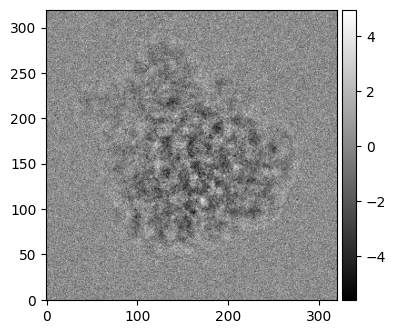

In [7]:
# Get an image, normalize, and plot it
from cryojax.image import normalize_image

fig, ax = plt.subplots(figsize=(4, 4))
observed_image = normalize_image(relion_particle.image_stack, is_real=True)
plot_image(observed_image, fig, ax)
print(
    "Image mean:",
    observed_image.mean(),
    "Image standard deviation:",
    observed_image.std(),
)

This particular image happens to be simulated with `cryojax` from the structure of the human 80S ribosome (PDB id 4gu0). In order to simulate the image, a scattering potential was computed and written to a voxel grid using the [`cisTEM`](https://github.com/timothygrant80/cisTEM) simulation tool.

We can also use fancy indexing to access multiple particles at once.

In [16]:
# Access multiple images in the stack
relion_particles = dataset[0:3]
print(relion_particles.image_stack.shape)

(3, 320, 320)


Now, we see that the `image_stack` attribute has a leading dimension for each image. We can also inspect the metadata read from the STAR file by printing the `CTF`.

In [18]:
# Inspect the CTF
eqx.tree_pprint(relion_particles.ctf, short_arrays=False)

CTF(
  defocus_u_in_angstroms=Array([10040.533, 10040.533, 10040.533], dtype=float32),
  defocus_v_in_angstroms=Array([9983.732, 9983.732, 9983.732], dtype=float32),
  astigmatism_angle=Array([-77.18247, -77.18247, -77.18247], dtype=float32),
  voltage_in_kilovolts=Array(300., dtype=float32),
  spherical_aberration_in_mm=Array(300., dtype=float32),
  amplitude_contrast_ratio=Array(0.1, dtype=float32),
  phase_shift=Array([0., 0., 0.], dtype=float32)
)


Notice that not all attributes of the `CTF` have a leading dimension. For those familiar with RELION STAR format, only the `CTF` parameters stored on a per-particle basis have a leading dimension! Parameters stored in the opticsGroup do not have a leading dimension.

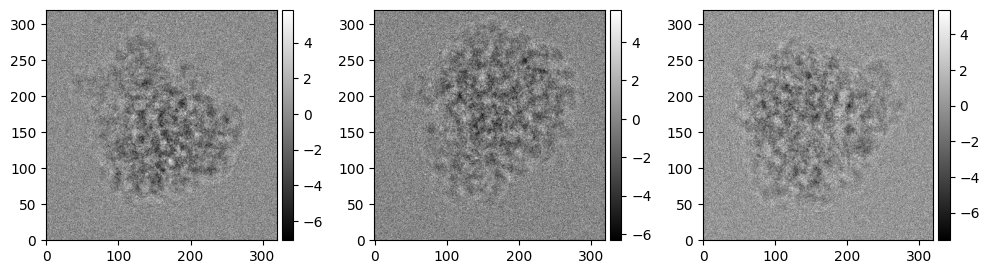

In [19]:
# Plot multiple images from the particle stack
fig, axes = plt.subplots(figsize=(10, 5), ncols=3)
[plot_image(relion_particles.image_stack[idx], fig, axes[idx]) for idx in range(3)]
plt.tight_layout()

Computing the power spectrum of an image is a common analysis tool in cryo-EM. This can be done in `cryojax`!

First, we simply have to compute our image in fourier space and a grid of wave vector magnitudes.

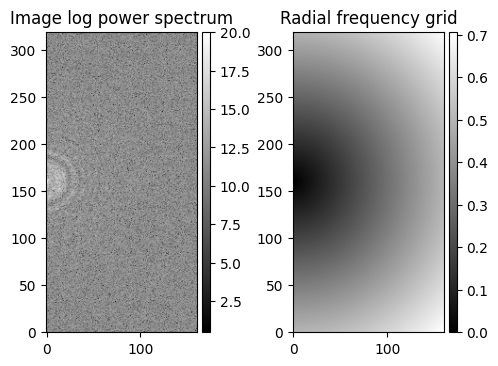

In [47]:
from cryojax.image import rfftn

# Get the particle
relion_particle = dataset[0]
# ... and the image in fourier space
fourier_image = rfftn(relion_particle.image_stack)
# ... and the cartesian coordinate system
pixel_size = relion_particle.config.pixel_size
frequency_grid_in_angstroms = (
    relion_particle.config.wrapped_frequency_grid_in_angstroms.get()
)
# ... now, compute a radial coordinate system
radial_frequency_grid_in_angstroms = jnp.linalg.norm(
    frequency_grid_in_angstroms, axis=-1
)
# ... plot the image in fourier space and the radial frequency grid
fig, axes = plt.subplots(figsize=(5, 4), ncols=2)
plot_image(
    jnp.log(jnp.abs(jnp.fft.fftshift(fourier_image, axes=(0,))) ** 2),
    fig,
    axes[0],
    label="Image log power spectrum",
)
plot_image(
    jnp.fft.fftshift(radial_frequency_grid_in_angstroms * pixel_size, axes=(0,)),
    fig,
    axes[1],
    label="Radial frequency grid",
)
plt.tight_layout()

We are now ready to compute and plot the radially averaged power spectrum profile! This simply bins the squared fourier amplitudes according to the `radial_frequency_grid`.

[Text(0.5, 0, 'wavenumber'), Text(0, 0.5, 'power spectrum'), None]

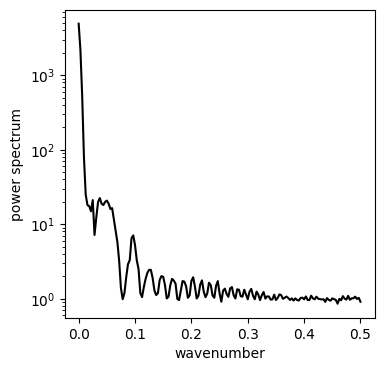

In [48]:
import math
from cryojax.image import powerspectrum

fig, ax = plt.subplots(figsize=(4, 4))
N_pixels = math.prod(relion_particle.config.shape)
spectrum, wavenumbers = powerspectrum(
    fourier_image,
    radial_frequency_grid_in_angstroms,
    pixel_size,
    k_max=1 / (2 * pixel_size),
)
ax.plot(pixel_size * wavenumbers, spectrum / N_pixels, color="k")
ax.set(xlabel="wavenumber", ylabel="power spectrum", yscale="log")

In [53]:
from cryojax.io import write_image_stack_to_mrc

write_image_stack_to_mrc(
    dataset[:4].image_stack[:, ::4, ::4], pixel_size * 4, "example_image_stack.mrcs"
)

In [52]:
dataset[:4].image_stack[:, ::4, ::4].shape

(4, 80, 80)